In [1]:
!pip uninstall tensorflow
!pip install tensorflow===1.13.1

Uninstalling tensorflow-1.13.1:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.13.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? n


In [2]:
# パッケージ のインポート
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Conv2D, Add, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
# データセットの準備
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# データセットのシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
# データセットのラベルの前処理
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(50000, 10)
(10000, 10)


In [0]:
# 畳み込み層の生成
def conv(filters, kernel_size, strides=1):
  return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, 
                kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

In [0]:
# 残差ブロックAの生成
def first_residual_unit(filters, strides):
  def f(x):
    # ->BN ->ReLU
    x = BatchNormalization()(x)
    b = Activation('relu')(x)
    
    # ->畳み込み層　->BN -> ReLU
    x = conv(filters // 4, 1, strides)(b)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ->畳み込み層　->BN -> ReLU
    x = conv(filters // 4, 3, strides)(b)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 畳み込み層　->
    x = conv(filters, 1)(x)

    # ショートカットのシェイプサイズの調整
    sc = conv(filters, 1, strides)(b)

    # Add
    return Add()([x, sc])

  return f

In [0]:
# 残差ブロックBの生成
def second_residual_unit(filters, strides):
  def f(x):
    sc = x

    # ->BN ->ReLU
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ->畳み込み層　->BN ->ReLU
    x = conv(filters // 4, 1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ->畳み込み層　->BN ->ReLU
    x = conv(filters // 4, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 畳み込み層　->
    x = conv(filters, 1)(x)

    # Add
    return Add()([x, sc])

  return f

In [0]:
# 残差ブロックAと残差ブロックB*17の生成
def residual_block(filters, strides, unit_size):
  def f(x):
    x = first_residual_unit(filters, strides)(x)
    for i in range(unit_size - 1):
      x = second_residual_unit(filters, strides)(x)

    return x

  return f

In [9]:
# 入力データのシェイプ
inputs = Input(shape=(32, 32, 3))

# 畳み込み層
x = conv(16, 3)(inputs)

# 残差ブロック * 54
x = residual_block(64, 1, 18)(x)
x = residual_block(128, 2, 18)(x)
x = residual_block(256, 2, 18)(x)

# ->BN ->ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# プーリング層
x = GlobalAveragePooling2D()(x)

# 全結合層
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

# モデルの作成
model = Model(inputs=inputs, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# ImageDataGeneratorの準備
train_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# データセット全体の統計量をあらかじめ計算
for data in (train_gen, test_gen):
  data.fit(train_images)

In [0]:
# LearningRateSchedulerの準備
def step_decay(epoch):
  x = 0.1
  if epoch >= 80:
    x = 0.01
  if epoch >= 120:
    x = 0.001
  return x

lr_decay = LearningRateScheduler(step_decay)

In [12]:
# TPU
import tensorflow as tf

tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu_cluster_resolver)
tpu_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.121.232.218:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10201173568795140548)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12876428935821961511)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8114912571970527287)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TP

In [13]:
tpu_model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

INFO:tensorflow:Cloning SGD {'lr': 0.009999999776482582, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}


In [20]:
print(type(lr_decay))

<class 'tensorflow.python.keras.callbacks.LearningRateScheduler'>


In [22]:
#学習
batch_size = 4096

history = tpu_model.fit_generator(
    train_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=200,
    steps_per_epoch= 50000 // batch_size,
    validation_data=test_gen.flow(test_images, test_labels, batch_size=batch_size),
    validation_steps= 10000 // batch_size,
    callbacks=[lr_decay]
)

Epoch 1/200
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(512,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(512, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(512, 10), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 0.10000000149011612, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7f9f63d5c4a8> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 86.1443281173706 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.10000000149011612 {0.1}
INFO:tensorflow:CPU -> TPU momentum: 0.8999999761581421 {0.9}
INFO:tensorflow:CPU

In [25]:
tpu_model.save_weights('resnet_weights.h5')

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU momentum: 0.8999999761581421
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU nesterov: False


In [0]:
tpu_model.load_weights('resnet_weights.h5')

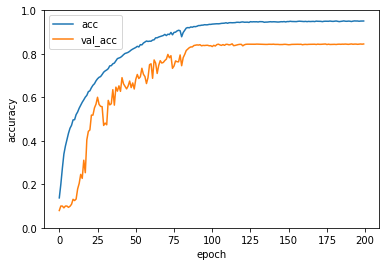

In [29]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.ylim((0, 1.0))
plt.show()

In [30]:
# 評価
batch_size = 128
test_loss, test_acc = tpu_model.evaluate_generator(
    test_gen.flow(test_images, test_labels, batch_size=batch_size),
    steps=10
)

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7f9f0f39d668> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 40.87402606010437 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.1}
INFO:tensorflow:CPU -> TPU momentum: 0.8999999761581421 {0.9}
INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(2, 32, 32, 3), dtype=tf.float32, name='input_1_10

In [31]:
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc))

loss: 2.210
acc: 0.845


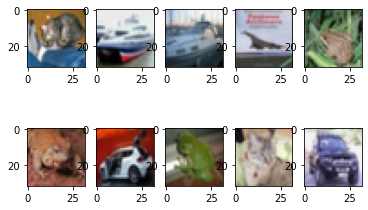

['cat', 'ship', 'automobile', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']
['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [45]:
# 推論する画像の表示
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(test_images[i])
plt.show()

# 推論したラベルの表示
test_predictions = tpu_model.predict_generator(
    test_gen.flow(test_images[:128], shuffle=False, batch_size=128),
    steps = 10
)
test_predictions = np.argmax(test_predictions, axis=1)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions[:10]])
print([labels[n] for n in np.argmax(test_labels[:10], axis=1)])